# Wykorzystanie rozkładów macierzy do rozwiązywania oznaczonych układów równań

Poznane na wykładzie rozkłady (faktoryzacje) macierzy możemy wykorzystać do rozwiązywania układów równań liniowych. Dzięki wykorzystaniu specjalnych własności macierzy występujących w rozkładzie jesteśmy w stanie w łatwiejszy sposób odwrócić macierz i tym samym zminimalizować błąd.


**Zadanie 1.**

Rozważmy układ równań $Ax=b$, w którym:
* $A$ jest macierzą Hilberta o wymiarach 15x15.
* $A$ jest macierzą wartości losowych z przedziału $[0,100]$ o wymiarach 100x100,  1000x1000 i 1000000x1000000.
* $b$ jest wektorem wartości losowych, odpowiednio, o wymiarach 15x1, 100x1, 1000x1 i 1000000x1.

1. Oblicz współczynnik uwarunkowania macierzy $A$ i oceń jej uwarunkowanie.
2. Rozwiąż układ równań następującymi metodami:
    * z użyciem jawnej odwrotności $A$.
    * korzystając z rozkładu [LU](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu.html) (uwaga na macierz permutacji!):
        * z wykorzystaniem odwrotności L i U.
        * z użyciem jedynie odwrotności i metody podstawiania wstecznego.
    * korzystając z rozkładu [QR](https://numpy.org/doc/stable/reference/generated/numpy.linalg.qr.html):
        * z wykorzystaniem odwrotności Q i R.
        * z użyciem jedynie odwrotności Q i metody podstawiania wstecznego.
    * za pomocą jednej z metod iteracyjnych z poprzedniego ćwiczenia.
    * za pomocą metody [`solve`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html) z pakietu NumPy.
3. Porównaj otrzymane wyniki. W tym celu oblicz normy z residuuów otrzymanych dla każdego z rozwiązań. Którą z metod cechuje najwyższa dokladność?
4. Przeprowadź porównanie wydajności ww. metod. Zmierz czas wykonania każdej metody. Aby otrzymać bardziej sensowny wynik należy powtórzyć obliczenia w pętli (np. 100 lub 1000 razy) i uśrednić wynik. Do pomiaru czasu wykonania możesz wykorzystać pakiet `time`.
Wskazówka: Do rozwiązania układu z macierzą trójkątną możesz wykorzystać funkcję [`scipy.linalg.solve_triangular`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_triangular.html).

        
        


In [7]:
import numpy as np
import scipy.linalg
import time

# Obliczanie normy residuum
def norma_residuum(A, x, b):
    return np.linalg.norm(A @ x - b)

# Mierzenie średniego czasu
def sredni_czas(funkcja, powtorzenia, A, b):
    start = time.time()
    for _ in range(powtorzenia):
        funkcja(A, b)
    end = time.time()
    return (end - start) / powtorzenia

# 1. Jawna odwrotność
def metoda_odwrotnosci(A, b):
    return np.linalg.inv(A) @ b

# 2a. Rozkład LU z odwrotnościami
def metoda_lu_odwrotnosc(A, b):
    P, L, U = scipy.linalg.lu(A)
    y = np.linalg.inv(L) @ (P @ b)
    return np.linalg.inv(U) @ y

# 2b. Rozkład LU z podstawianiem
def metoda_lu_podstawianie(A, b):
    P, L, U = scipy.linalg.lu(A)
    y = scipy.linalg.solve_triangular(L, P @ b, lower=True)
    return scipy.linalg.solve_triangular(U, y)

# 3a. Rozkład QR z odwrotnościami
def metoda_qr_odwrotnosc(A, b):
    Q, R = np.linalg.qr(A)
    return np.linalg.inv(R) @ (Q.T @ b)

# 3b. Rozkład QR z podstawianiem
def metoda_qr_podstawianie(A, b):
    Q, R = np.linalg.qr(A)
    y = Q.T @ b
    return scipy.linalg.solve_triangular(R, y)

# 4. Iteracyjna metoda Gaussa-Seidla
def metoda_iteracyjna(A, b, max_iter=1000, tol=1e-10):
    x = np.zeros_like(b)
    for _ in range(max_iter):
        x_nowe = np.copy(x)
        for i in range(len(b)):
            s1 = np.dot(A[i, :i], x_nowe[:i])
            s2 = np.dot(A[i, i+1:], x[i+1:])
            x_nowe[i] = (b[i] - s1 - s2) / A[i, i]
        if np.linalg.norm(x - x_nowe) < tol:
            break
        x = x_nowe
    return x

# 5. Wbudowana funkcja numpy.solve
def metoda_numpy(A, b):
    return np.linalg.solve(A, b)

# WYBÓR MACIERZY
n = 15  # zmień np. na 100 lub 1000
A = scipy.linalg.hilbert(n)  # dla Hilberta
# A = np.random.rand(n, n) * 100  # dla losowej macierzy
b = np.random.rand(n)

# Uwarunkowanie
uwarunkowanie = np.linalg.cond(A)
print("Współczynnik uwarunkowania:", uwarunkowanie)

# TESTY WSZYSTKICH METOD
metody = {
    "Jawna odwrotność": metoda_odwrotnosci,
    "LU (odwrotność)": metoda_lu_odwrotnosc,
    "LU (podstawianie)": metoda_lu_podstawianie,
    "QR (odwrotność)": metoda_qr_odwrotnosc,
    "QR (podstawianie)": metoda_qr_podstawianie,
    "Iteracyjna": metoda_iteracyjna,
    "NumPy solve": metoda_numpy
}

for nazwa, metoda in metody.items():
    try:
        x = metoda(A, b)
        res = norma_residuum(A, x, b)
        czas = sredni_czas(metoda, 100, A, b)
        print(f"{nazwa:20s} | Norma residuum: {res:.2e} | Średni czas: {czas:.6f} s")
    except Exception as e:
        print(f"{nazwa:20s} | Błąd: {e}")




Współczynnik uwarunkowania: 3.67568286586649e+17
Jawna odwrotność     | Norma residuum: 3.91e+00 | Średni czas: 0.000376 s
LU (odwrotność)      | Norma residuum: 1.72e+00 | Średni czas: 0.001265 s
LU (podstawianie)    | Norma residuum: 2.51e+00 | Średni czas: 0.000310 s
QR (odwrotność)      | Norma residuum: 1.81e+00 | Średni czas: 0.000558 s
QR (podstawianie)    | Norma residuum: 1.32e+00 | Średni czas: 0.000200 s
Iteracyjna           | Norma residuum: 8.08e-01 | Średni czas: 0.195548 s
NumPy solve          | Norma residuum: 2.68e+00 | Średni czas: 0.000030 s


# Interpolacja

**Zadanie 2.**

Przeprowadź interpolacje poniższych funkcji $f(x)$ za pomocą wielomianów interpolacyjnych Lagrange'a ([`scipy.interpolate.lagrange`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.lagrange.html)). Stwórz wykresy funkcji interpolacyjnych i zaznacz na nich punkty, w ktorych dokonano oceny wartości funkcji.

Pierwsza funkcja:

* $f(0) = 1$,
* $f(0.25) = 1.64872$,
* $f(0.5) = 2.71828$,
* $f(0.75) = 4.48169.$

Oblicz $f(0.43)$.

Druga funkcja:

* $f_2(0.1) = 0.62049958$,
* $f_2(0.2) = -0.28398668$,
* $f_2(0.3) = 0.00660095$,
* $f_2(0.4) = 0.24842440$. 

Oblicz $f_2(0.25)$.

f(0.43) = 2.360604734079999


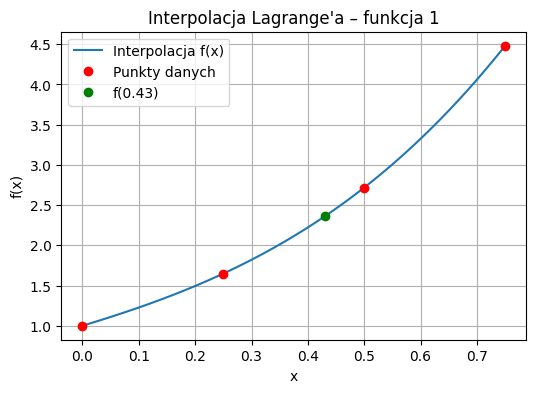

f2(0.25) = -0.21033722187500237


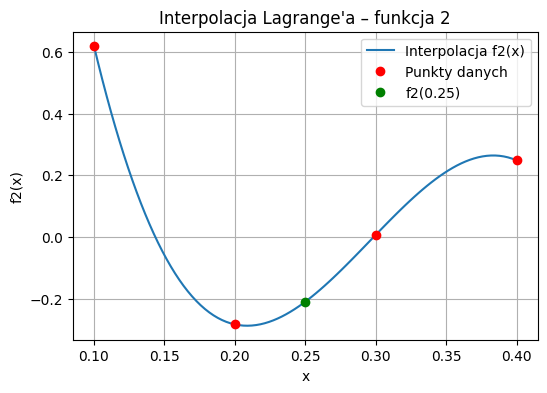

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange

# Funkcja 1: dane
x1 = [0, 0.25, 0.5, 0.75]
y1 = [1, 1.64872, 2.71828, 4.48169]

# Interpolacja Lagrange'a
wielomian1 = lagrange(x1, y1)

# Obliczenie f(0.43)
x_oblicz1 = 0.43
y_oblicz1 = wielomian1(x_oblicz1)
print("f(0.43) =", y_oblicz1)

# Wykres
x_wykres1 = np.linspace(0, 0.75, 100)
y_wykres1 = wielomian1(x_wykres1)

plt.figure(figsize=(6, 4))
plt.plot(x_wykres1, y_wykres1, label="Interpolacja f(x)")
plt.plot(x1, y1, 'ro', label="Punkty danych")
plt.plot(x_oblicz1, y_oblicz1, 'go', label="f(0.43)")
plt.title("Interpolacja Lagrange'a – funkcja 1")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()

# Funkcja 2: dane
x2 = [0.1, 0.2, 0.3, 0.4]
y2 = [0.62049958, -0.28398668, 0.00660095, 0.24842440]

# Interpolacja
wielomian2 = lagrange(x2, y2)

# Obliczenie f2(0.25)
x_oblicz2 = 0.25
y_oblicz2 = wielomian2(x_oblicz2)
print("f2(0.25) =", y_oblicz2)

# Wykres
x_wykres2 = np.linspace(0.1, 0.4, 100)
y_wykres2 = wielomian2(x_wykres2)

plt.figure(figsize=(6, 4))
plt.plot(x_wykres2, y_wykres2, label="Interpolacja f2(x)")
plt.plot(x2, y2, 'ro', label="Punkty danych")
plt.plot(x_oblicz2, y_oblicz2, 'go', label="f2(0.25)")
plt.title("Interpolacja Lagrange'a – funkcja 2")
plt.xlabel("x")
plt.ylabel("f2(x)")
plt.grid(True)
plt.legend()
plt.show()


***Zadanie 3.***

Rozważmy funkcję $f(x)=\frac{1}{25x^2+1}$. 

Przeprowadź interpolacje funkcji $f$ w przedziale $[-2,2]$ wielomianem Lagrange'a oraz funkcjami sklejanymi 3 stopnia w:
- 21 równoodległych węzłach,
- 21 węzłach [Czebyszewa](https://pl.wikipedia.org/wiki/Węzły_Czebyszewa).

**Wskazówka** Interpolację funkcjami sklejanymi możesz przeprowadzić za pomocą funkcji [`interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d).

Umieść wielomian interpolacyjny, oryginalną funkcję $f$ oraz węzly interpolacyjne na wspólnym wykresie (jeden wykres dla metody Lagrange'a oraz jeden dla funkcji sklejanych). Porównaj otrzymane rezultaty. Przeprowadź te same działania dla przedziału $x\in[-5,5]$. Jakie problemy możesz zauważyć na otrzymanych wykresach?

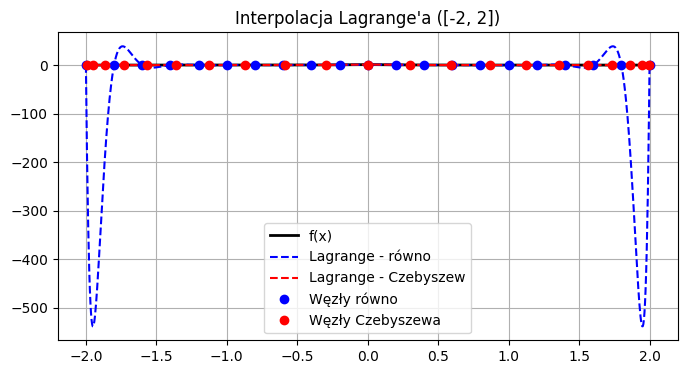

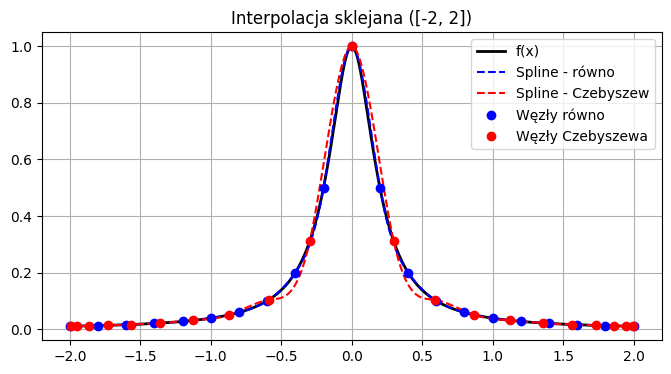

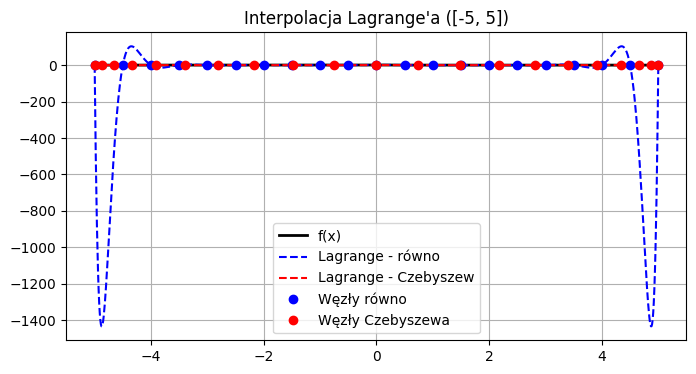

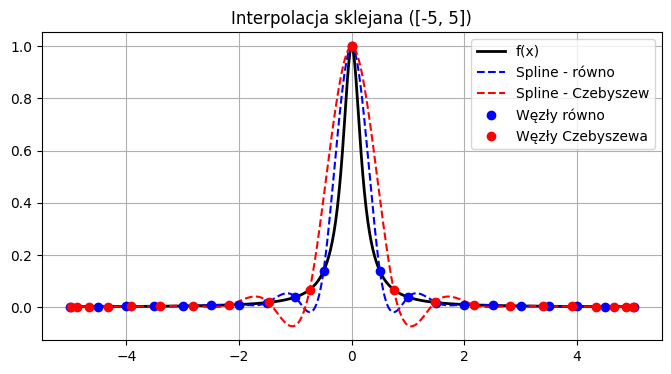

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange, interp1d

def f(x):
    return 1 / (25 * x**2 + 1)

def wezly_rownoodlegle(a, b, n):
    return np.linspace(a, b, n)

def wezly_czebyszewa(a, b, n):
    i = np.arange(1, n + 1)
    return 0.5 * (a + b) + 0.5 * (b - a) * np.cos((2 * i - 1) * np.pi / (2 * n))

def rysuj_interpolacje(a, b, n, opis):
    x_dokladne = np.linspace(a, b, 1000)
    y_dokladne = f(x_dokladne)

    # Równoodległe węzły
    x_rowne = wezly_rownoodlegle(a, b, n)
    y_rowne = f(x_rowne)
    
    # Czebyszewa węzły
    x_czeb = wezly_czebyszewa(a, b, n)
    y_czeb = f(x_czeb)

    # --- LAGRANGE ---
    lagrange_rowne = lagrange(x_rowne, y_rowne)
    lagrange_czeb = lagrange(x_czeb, y_czeb)

    # --- SPLAJNY (poprawka: allow extrapolation) ---
    spline_rowne = interp1d(x_rowne, y_rowne, kind='cubic', bounds_error=False, fill_value="extrapolate")
    spline_czeb = interp1d(x_czeb, y_czeb, kind='cubic', bounds_error=False, fill_value="extrapolate")

    # --- Rysuj Lagrange ---
    plt.figure(figsize=(8, 4))
    plt.plot(x_dokladne, y_dokladne, 'k-', label='f(x)', linewidth=2)
    plt.plot(x_dokladne, lagrange_rowne(x_dokladne), 'b--', label='Lagrange - równo')
    plt.plot(x_dokladne, lagrange_czeb(x_dokladne), 'r--', label='Lagrange - Czebyszew')
    plt.plot(x_rowne, y_rowne, 'bo', label='Węzły równo')
    plt.plot(x_czeb, y_czeb, 'ro', label='Węzły Czebyszewa')
    plt.title(f'Interpolacja Lagrange\'a ({opis})')
    plt.grid()
    plt.legend()
    plt.show()

    # --- Rysuj Spline ---
    plt.figure(figsize=(8, 4))
    plt.plot(x_dokladne, y_dokladne, 'k-', label='f(x)', linewidth=2)
    plt.plot(x_dokladne, spline_rowne(x_dokladne), 'b--', label='Spline - równo')
    plt.plot(x_dokladne, spline_czeb(x_dokladne), 'r--', label='Spline - Czebyszew')
    plt.plot(x_rowne, y_rowne, 'bo', label='Węzły równo')
    plt.plot(x_czeb, y_czeb, 'ro', label='Węzły Czebyszewa')
    plt.title(f'Interpolacja sklejana ({opis})')
    plt.grid()
    plt.legend()
    plt.show()

# --- Uruchom dla [-2, 2] ---
rysuj_interpolacje(-2, 2, 21, '[-2, 2]')

# --- Uruchom dla [-5, 5] ---
rysuj_interpolacje(-5, 5, 21, '[-5, 5]')


***Zadanie 4.***

Kierowca jadący z miasta A do miasta B, zauważywszy na drodze fotoradar, zaczął gwałtownie hamować. Przebieg jego położenia, zarejestrowany przez nawigację, pokazano w poniższej tabeli. Wiedząc, że radar znajduje się w punkcie o współrzędnej 79.6 m, oszacuj kiedy kierowca minął fotoradar (w tym celu skorzystaj z jednej z metod z laboratorium 3) oraz z jaką prędkością wtedy jechał (wykorzystaj relację drogi i prędkości znaną z fizyki). 

|czas \[s\]|położenie \[m\]|
|--|--|
|0.0|0.0|
|1.0|42.7|
|2.0|73.2|
|3.0|92.5|

Kierowca minął fotoradar w czasie t = 2.276 s
Prędkość w tym momencie: v = 21.68 m/s


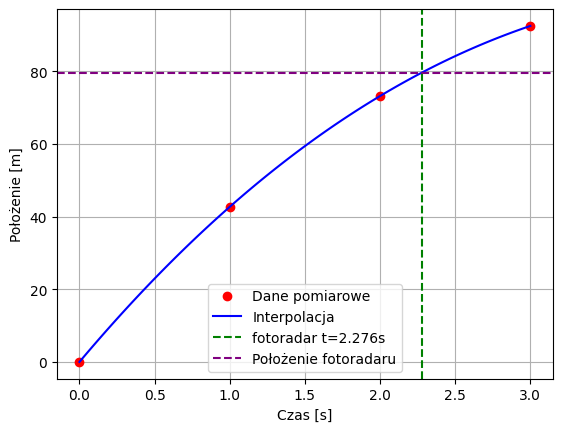

In [25]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import brentq
import matplotlib.pyplot as plt

# Dane: czas [s] i położenie [m]
czas = np.array([0.0, 1.0, 2.0, 3.0])
pozycja = np.array([0.0, 42.7, 73.2, 92.5])

# Interpolacja położenia względem czasu (cubic spline)
interp_pozycja = interp1d(czas, pozycja, kind='cubic')

# Szukamy czasu, gdy pozycja = 79.6
def roznica(t):
    return interp_pozycja(t) - 79.6

# Zakładamy, że kierowca przejechał fotoradar między 2 a 3 sek.
t_min = brentq(roznica, 2.0, 3.0)
print(f"Kierowca minął fotoradar w czasie t = {t_min:.3f} s")

# Przybliżona prędkość to pochodna położenia względem czasu
# Obliczymy ją numerycznie metodą różnic centralnych:
h = 1e-5
v = (interp_pozycja(t_min + h) - interp_pozycja(t_min - h)) / (2 * h)
print(f"Prędkość w tym momencie: v = {v:.2f} m/s")

# Dla wizualizacji:
t_plot = np.linspace(0, 3, 100)
plt.plot(czas, pozycja, 'ro', label='Dane pomiarowe')
plt.plot(t_plot, interp_pozycja(t_plot), 'b-', label='Interpolacja')
plt.axvline(t_min, color='g', linestyle='--', label=f'fotoradar t={t_min:.3f}s')
plt.axhline(79.6, color='purple', linestyle='--', label='Położenie fotoradaru')
plt.xlabel('Czas [s]')
plt.ylabel('Położenie [m]')
plt.legend()
plt.grid()
plt.show()


**Zadanie dla zainteresowanych programowaniem funkcyjnym w Pythonie**

Stwórz funkcję znajdującą wielomian interpolacyjny metodą Lagrange'a. Funkcja powinna przyjmować dwie listy:
* listę argumentów ($x$-ów)
* listę wartości ($y$-ów).  


Po wykonaniu obliczeń funkcja powinna zwracać wielomian w postaci obiektu typu **funkcja** (a nie `numpy.Polynomial`).

**Wskazówka** Wykorzystaj wyrażenia *lambda*. Dla ułatwienia możesz się też posłużyć pakietami `operator` i `functools`.
